In [82]:
using Pkg
Pkg.add("NPZ")
Pkg.add("Healpix")
Pkg.add("Plots")
Pkg.add("PlotlyJS")
Pkg.add("PyCall")
Pkg.add("DataFrames")
Pkg.add("Pandas")
Pkg.add("Glob")

using NPZ
using Healpix
using Plots
using PyCall
using DataFrames
import Pandas
import Glob

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
   Installed Hiccup ──────────────── v0.2.2
   Installed Pidfile ─────────────── v1.3.0
   Installed PlotlyBase ──────────── v0.8.19
   Installed WebSockets ──────────── v1.6.0
   Installed AssetRegistry ───────── v0.1.0
   Installed Kaleido_jll ─────────── v0.2.1+0
   Installed Mustache ────────────── v1.0.18
   Installed UnPack ──────────────── v1.0.2
   Installed PlotlyJS ────────────── v0.18.11
   Installed JSExpr ──────────────── v0.5.4
   Installed Widgets ─────────────── v0.6.6
   Installed FunctionalColl

In [4]:
#ENV["PYTHON"]=""
#Pkg.build("PyCall")

    Building Conda ─→ `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/8c86e48c0db1564a1d49548d3515ced5d604c408/build.log`
    Building PyCall → `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/43d304ac6f0354755f1d60730ece8c499980f7ba/build.log`
Precompiling project...
  ✓ PyCall
  1 dependency successfully precompiled in 10 seconds. 168 already precompiled.
  1 dependency precompiled but a different version is currently loaded. Restart julia to access the new version


In [260]:
function test_projections(folder, theta, phi)
    # Load the data from .npy file
    outdata = npzread("$folder/of_surface.npy")
    indata = npzread("$folder/if_surface.npy")
    target = npzread("$folder/tf_surface.npy")
    df = Pandas.read_pickle(Glob.glob("$folder/checkpoints/**/df.pickle")[1])
    
    # Assuming the data is a 1D array representing a HEALPix map, create a HEALPix map
    nside = Healpix.npix2nside(size(outdata)[3])
    hpx_map_in = HealpixMap{Float32, NestedOrder}(nside)
    hpx_map_out = HealpixMap{Float32, NestedOrder}(nside)
    hpx_area = HealpixMap{Float32, NestedOrder}(nside)
    hpx_map_target = HealpixMap{Float32, NestedOrder}(nside)
    hpx_map_in.pixels[:] = 10.0 * (1:Healpix.nside2npix(nside)) / Healpix.nside2npix(nside) #indata[1, 1, :]
    hpx_map_out.pixels[:] = outdata[1, 1, :]
    hpx_map_target.pixels[:] = abs.(outdata[1, 1, :] - target[1, 1, :])
    hpx_area[:] .= 0.0
    pixels_ring = queryDiscRing(Resolution(nside), deg2rad(180 - theta), deg2rad(phi), deg2rad(20.0))
    pixels_nest = [Healpix.ring2nest(Resolution(nside), pixel) for pixel in pixels_ring]
    hpx_area[pixels_nest] .= 10.0
    clims = extrema([hpx_map_in.pixels; hpx_map_out.pixels; hpx_map_target.pixels])
    cb = scatter([0,0], [0,1], zcolor=[0,3], clims=clims,
                 xlims=(1,1.1), xshowaxis=false, yshowaxis=false, label="", c=:viridis, colorbar_title="cbar", grid=false)
    p1 = plot(hpx_map_in, title="input", colorbar=false, clims=clims, c=:viridis)
    p2 = plot(hpx_map_out, title="prediction", colorbar=false, clims=clims, c=:viridis)
    p1 = plot!(p1, hpx_area, alpha=0.2, colorbar=false, clims=clims, c=:viridis)
    p2 = plot(hpx_map_in, title="input", colorbar=false, clims=clims, c=:viridis)
    #p1 = plot(hpx_area, alpha=0.2, colorbar=false, clims=clims, c=:viridis)
    #p3 = plot(hpx_map_target, title="abs(prediction-target)")
    p3 = plot(
        hpx_map_in, 
        gnomonic, 
        Dict(
            :fov_rad => deg2rad(20.0), 
            :center => (
                colat2lat(deg2rad(theta)), 
                deg2rad(phi), 
                deg2rad(180.0))), 
        colorbar=false, clims=clims, c=:viridis)
    p4 = plot(Array(df["epoch"]), Array(df["non_reducing_loss"]), title="loss", xlabel="epoch", ylabel="loss", yaxis=:log)
    val_loss = filter(x -> x[2] > 0, collect(zip(Array(df["epoch"]), Array(df["val_non_reducing_loss"]))))
    val_loss_plot = plot([x[1] for x in val_loss], [x[2] for x in val_loss], title="val_loss")
    #p42 = PlotlyJS.plot([p4, val_loss_plot]) 
    plot!(p4, [x[1] for x in val_loss], [x[2] for x in val_loss], title="val_loss")
    plot(p1, p2, p3, p4, cb, size=(1000,1000), plot_title="$folder")
    ##[p1 p2; p3 p4]
end

test_projections (generic function with 1 method)

In [305]:
function plot_diff(folder, theta, phi, cs=:thermal; variable=1)
    # Load the data from .npy file
    outdata = npzread("$folder/of_surface.npy")
    indata = npzread("$folder/if_surface.npy")
    target = npzread("$folder/tf_surface.npy")
    df = Pandas.read_pickle(Glob.glob("$folder/checkpoints/**/df.pickle")[1])
    
    # Assuming the data is a 1D array representing a HEALPix map, create a HEALPix map
    nside = Healpix.npix2nside(size(outdata)[3])
    hpx_map_in = HealpixMap{Float32, NestedOrder}(nside)
    hpx_map_out = HealpixMap{Float32, NestedOrder}(nside)
    hpx_area = HealpixMap{Float32, NestedOrder}(nside)
    hpx_map_target_diff = HealpixMap{Float32, NestedOrder}(nside)
    hpx_map_in.pixels[:] = indata[1, variable, :]
    hpx_map_out.pixels[:] = outdata[1, variable, :]
    hpx_map_target_diff.pixels[:] = abs.(outdata[1, variable, :] - target[1, variable, :])
    hpx_area[:] .= 0.0
    pixels_ring = queryDiscRing(Resolution(nside), deg2rad(180 - theta), deg2rad(phi), deg2rad(20.0))
    pixels_nest = [Healpix.ring2nest(Resolution(nside), pixel) for pixel in pixels_ring]
    hpx_area[pixels_nest] .= 10.0
    clims = extrema([hpx_map_in.pixels; hpx_map_out.pixels; hpx_map_target_diff.pixels])
    cb = scatter([0,0], [0,1], zcolor=[0,3], clims=clims,
                 xlims=(1,1.1), xshowaxis=false, yshowaxis=false, label="", c=cs, colorbar_title="cbar", grid=false)
    p1 = plot(hpx_map_in, title="input", colorbar=false, clims=clims, c=cs)
    p2 = plot(hpx_map_out, title="prediction", colorbar=false, clims=clims, c=cs)
    p1 = plot!(p1, hpx_area, alpha=0.2, colorbar=false, clims=clims, c=cs)
    p2 = plot!(p2, hpx_area, alpha=0.2, colorbar=false, clims=clims, c=cs)
    #p2 = plot(hpx_map_in, title="input", colorbar=false, clims=clims, c=:viridis)
    #p1 = plot(hpx_area, alpha=0.2, colorbar=false, clims=clims, c=:viridis)
    diff = plot(hpx_map_target_diff, title="abs(prediction-target)")
    zoom_input = plot(
        hpx_map_in, 
        gnomonic, 
        Dict(
            :fov_rad => 1.2*deg2rad(20.0), 
            :center => (
                colat2lat(deg2rad(theta)), 
                deg2rad(phi), 
                deg2rad(0.0))), 
        colorbar=false, clims=clims, c=cs)
    zoom_output = plot(
        hpx_map_out, 
        gnomonic, 
        Dict(
            :fov_rad => 1.2*deg2rad(20.0), 
            :center => (
                colat2lat(deg2rad(theta)), 
                deg2rad(phi), 
                deg2rad(0.0))), 
        colorbar=false, clims=clims, c=cs)
    p4 = plot(Array(df["epoch"]), Array(df["non_reducing_loss"]), title="loss", xlabel="epoch", ylabel="loss", yaxis=:log)
    val_loss = filter(x -> x[2] > 0, collect(zip(Array(df["epoch"]), Array(df["val_non_reducing_loss"]))))
    val_loss_plot = plot([x[1] for x in val_loss], [x[2] for x in val_loss], title="val_loss")
    #p42 = PlotlyJS.plot([p4, val_loss_plot]) 
    plot!(p4, [x[1] for x in val_loss], [x[2] for x in val_loss], title="val_loss")
    #layout = @layout [[grid(2,2), {0.1w}], grid(2,1)]
    plot(p1, p2, zoom_input, zoom_output, diff, cb, p4, size=(1000,1000), plot_title="$folder", layout=(4, 2))
    ##[p1 p2; p3 p4]
end

plot_diff (generic function with 4 methods)

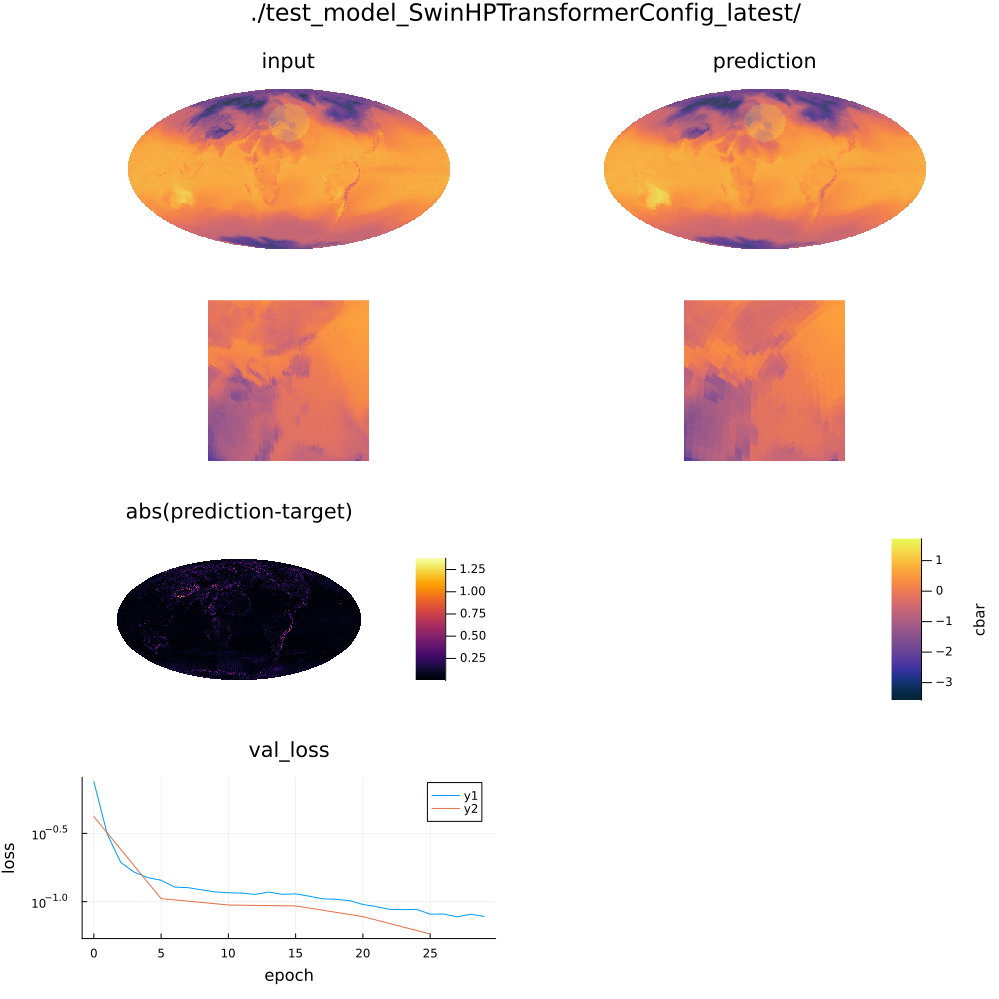

In [311]:
plot_diff("./test_model_SwinHPTransformerConfig_latest/", 180-45, 0, variable=4)

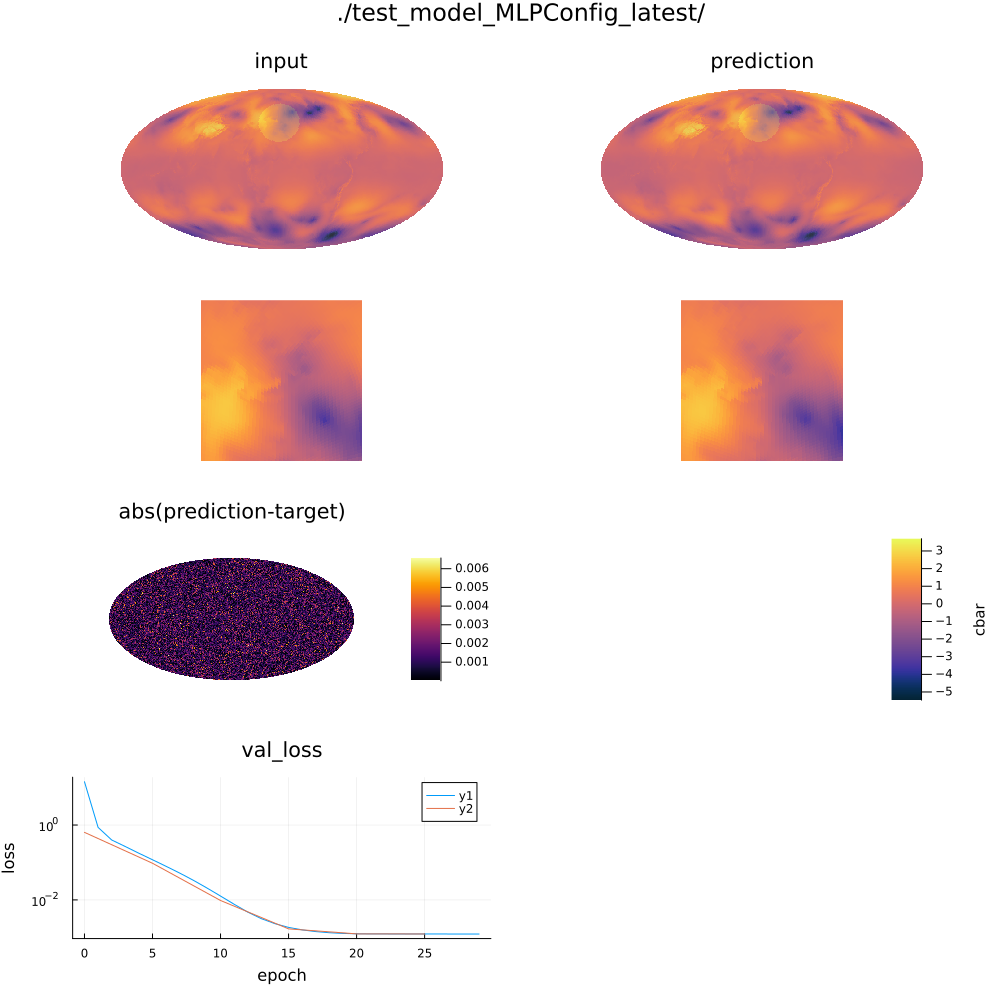

In [312]:
plot_diff("./test_model_MLPConfig_latest/", 180-45, 4)